In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
# 1. Preprocess silhouettes (đã test xong) chạy oke
# chuyển ảnh silhoute thành ảnh nhị phân trắng đen

def preprocess_silhouettes(folder_path):
    silhouettes = []
    # tạo danh sách đường dẫn của tất cả ảnh trong folder
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths: # kiểm tra đường dẫn hợp lệlệ
        raise ValueError("No valid image files found in the folder.")
    
    for path in image_paths: # đọc mỗi tấm ảnh và lấy ngưỡng cho nó
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️ Warning: Cannot read image at {path}")
            break
        
        _, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
        
        binary = binary[:,10:-10] # crop ảnh từ 64x64 thành 64x44
        silhouettes.append(binary)
        
    return np.array(silhouettes)

# test
path = "C:/Users/HUY/Desktop/my_project/data/001/bg-01/000"
sil = preprocess_silhouettes(path)
sil.shape # OKE

(89, 64, 44)

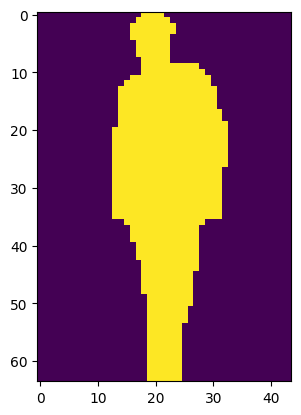

In [20]:
plt.imshow(sil[0])

In [21]:
# 2. Compute Gait Energy Image
# sử dụng ảnh silhoute trắng đen trước đó để tính ảnh GEI
def compute_gei(silhouettes):
    return np.mean(silhouettes, axis=0)

gei = compute_gei(sil)
print(gei.shape) # OKE

def show_image(image, title="Image", scale=7):
    h, w = image.shape[0], image.shape[1]
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    cv2.imshow(title, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
show_image(gei) # OKE

(64, 44)


In [14]:
# lưu ảnh vào thư mục đã chọn
def save_image(image, folder_path, image_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    save_path = f"{folder_path}/{image_name}"
    cv2.imwrite(save_path, image)
    print(f"✅ Image saved at {save_path}")

In [22]:
# hàm xử lý ảnh GEI back
root_folder = "C:/Users/HUY/Desktop/my_project/data"
bulk = "C:/Users/HUY/Desktop/my_project/bulk"
final_data = "C:/Users/HUY/Desktop/my_project/final_data"

def gei_process(root_folder, bulk):
    for object in os.listdir(root_folder):
        for folder in os.listdir(f"{root_folder}/{object}"):
            for direction in os.listdir(f"{root_folder}/{object}/{folder}"):
                binary_imgs = preprocess_silhouettes(f"{root_folder}/{object}/{folder}/{direction}")
                gei = compute_gei(binary_imgs)
                save_image((gei*255).astype(np.uint8), bulk, f"{object}-{folder}-{direction}.jpg")
                # save_image((gei*255).astype(np.uint8),f"{processed_data}/{object}/{folder}", f"{direction}.jpg") # backup 
    print("Processed all Gait Energy imgs!")
    
gei_process(root_folder, bulk) # OKE

✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-000.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-018.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-036.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-054.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-072.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-090.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-108.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-126.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-144.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-162.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-01-180.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-02-000.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-02-018.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/bulk/001-bg-02-

In [23]:
def split_data(bulk, final_path):
    # tạo folder lưu trữ dữ liệu
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    # tạo nơi lưu trữ tập huấn luyện
    train_path = f"{final_path}/train"
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    # tạo nơi lưu trữ tập kiểm tra
    test_path = f"{final_path}/test"
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    for img in os.listdir(bulk):
        if "nm-01" in img or "nm-02" in img or "nm-03" in img or "nm-04" in img:
            im = cv2.imread(f"{bulk}/{img}", cv2.IMREAD_GRAYSCALE)
            save_image(im,train_path,img)
            
        if "nm-05" in img or "nm-06" in img:
            im = cv2.imread(f"{bulk}/{img}", cv2.IMREAD_GRAYSCALE)
            save_image(im,test_path,img)

    print("Splitted all the data into train and test sets.")
    
split_data(bulk, final_data) # OKE

✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-000.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-018.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-036.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-054.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-072.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-090.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-108.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-126.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-144.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-162.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-01-180.jpg
✅ Image saved at C:/Users/HUY/Desktop/my_project/final_data/train/001-nm-02-

In [25]:
# tạo thêm ra các ảnh synthetic để làm cho bộ dữ liệu lớn hơn chút
import math
synthetic_path = "C:/Users/HUY/Desktop/my_project/synthetic_data"

def create_synthetic(final_data, synthetic_path, iter = 6, k = 1):
    train_path =  f"{synthetic_path}/train"
    test_path = f"{synthetic_path}/test"
    if not os.path.exists(synthetic_path):
        os.makedirs(synthetic_path)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    for folder in os.listdir(final_data):
        for im in os.listdir(f"{final_data}/{folder}"):
            image = cv2.imread(f"{final_data}/{folder}/{im}", cv2.IMREAD_GRAYSCALE)
            x, y = image.shape
            for i in range(1, 1 + iter):
                temp = np.copy(image)
                
                cut_bot = temp[0:x-i*k, :]
                cut_top = temp[i*k:x, :]
                
                cut_bot = cv2.resize(cut_bot, (y,x))
                cut_top = cv2.resize(cut_top, (y,x))
                
                im = im[0:13]
                if folder == "train": path = train_path
                else: path = test_path
                
                save_image(cut_bot, path , f"{im}-t-{i}.jpg ")
                # print({cut_bot.shape})
                save_image(cut_top, path, f"{im}-t-{i+iter}.jpg ")
                # print({cut_top.shape})
            
    print("Finished creating synthetic image")
            

create_synthetic(final_data, synthetic_path)

# cnt = 0
# for im in os.listdir(synthetic_path):
#     for i in os.listdir(f"{synthetic_path}/{im}"):
#         cnt+= 1
#     print(cnt)
#     cnt = 0
# số dữ liệu khá chuẩn theo tính toán, có điều dữ liệu người số năm bị thiếu góc chính diện 

✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-1.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-7.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-2.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-8.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-3.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-9.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-4.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-10.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-5.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05-000-t-11.jpg 
✅ Image saved at C:/Users/HUY/Desktop/my_project/synthetic_data/test/001-nm-05

In [ ]:
# HOÀN THÀNH TIỀN XỬ LÝ DỮ LIỆU
# > chia dữ liệu ra 2 tập train và test
# > tạo thêm 6 ảnh tổng tổnghopwj cho mỗi ảnh dữ liệu gốc
# > và chia ra thành các train và test